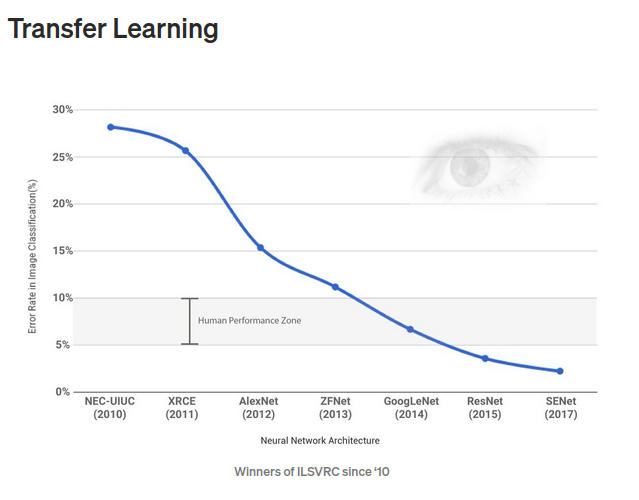

Since 2012, when AlexNet emerged, the deep learning based image classification task has been improved dramatically. Along the way, a lot of CNN models have been suggested. Even though some of them didn’t win the ILSVRC, they such as VGG16 have been popular because of their simpleness and low loss rate.

It takes couple of weeks to train the model against entire ImageNet database even with high end GPUs. It would be ideal if we can re-use the proved models from ILSVRC so we don’t need to spend a lot of time on training and verification. Transfer learning is exactly what we want.

Transfer learning is about borrowing CNN architecture with its pre-trained parameters from someone else. When we train our own data on the top of the pre-trained parameters, we can easily reach to the target accuracy.
Choice of model

Before diving in, you have to choose which model to choose. It is entirely related to your physical environment and the goal your team aims.

Since ILSVRC requires models to classify 1,000 categories of images, some suggested models couldn’t show super performance. However, if your goal is to classify 10 to 100 categories of images, the models could be fit into your situation.

As CNN models has been evolved, the recent ones show quite complicated architecture. If we want to change/modify certain portions of the entire layer, or if we want to trouble-shoot which portion is the bottleneck for our problem, It is critical to understand how models work behind the scene.

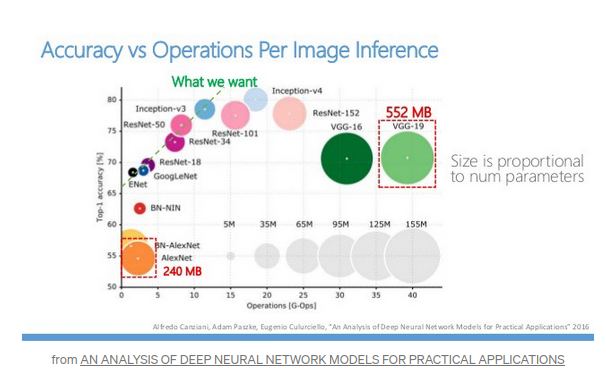

How big is the model? This often related to questions about the number of parameters or the number of layers. They number hints how long you need to spend time for training. Particularly, the number of parameters should be well considered when you use GPU hardware since GPU has a limited memory resources.

For my case, I chose the VGG19 model for some reasons. First, even though it didn’t win ILSVRC, it took the 2nd place showing nice performance. I only need 10 categories of images, so I though VGG19 is enough for CIFAR-10. Second, VGG19 architecture is very simple. If you understand the basic CNN model, you will instantly notice that VGG19 looks similar. Third, I have NVIDIA GTX 1080Ti which has 11GB memory. This one is not the best choice, but I thought it would be enough to run VGG19 even though VGG19 is a big in size. Lastly, since a lot of people uses VGG16, I wanted to give a shot with VGG19.

 You should know what is the last layer of the model in order to apply loss function , optimizer, and perform accuracy test.

### Summary
Before ending this story, I want to summarize briefly.
Transfer Learning is good starting point when you build up a image classification system
Choice of model depends on your physical(H/W) environments and the your team’s goal (how many categories?).
Choice of model implementation is not very important, but it would help streamlining the whole process.
When using third party implementation, you should know three things. ‘How to create model?’, ‘What is the last layer?’, and ‘How to load pre-trained parameters?’
It is important to know how to re-scale your own input images to fit into the chosen model (use skimage.transform package).
Batch size should be carefully considered depending on your physical (H/W) environment.

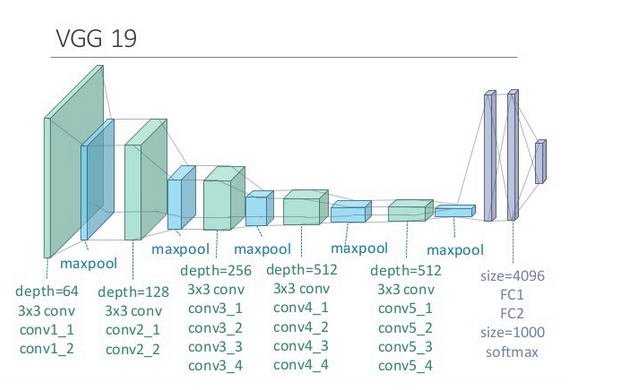

Implement pre-process Functions
You probably notice that some frameworks/libraries like TensorFlow, Numpy, or Scikit-learn provide similar functions to those I am going to build. This reflects my purpose of not heavily depending on frameworks or libraries. I believe in that I could make my own models better or reproduce/experiment the state-of-the-art models introduced in papers. For this story, I am going to implement normalize and one-hot-encode functions.
Normalize
normalize function takes data, x, and returns it as a normalized Numpy array. x can be anything, and it can be N-dimensional array. In this story, it will be 3-D array for an image. Min-Max Normalization (y = (x-min) / (max-min)) technique is used, but there are other options too. By applying Min-Max normalization, the original image data is going to be transformed in range of 0 to 1 (inclusive). A simple answer to why normalization should be performed is somewhat related to activation functions.

For example, sigmoid activation function takes an input value and outputs a new value ranging from 0 to 1. When the input value is somewhat large, the output value easily reaches the max value 1. Similarly, when the input value is somewhat small, the output value easily reaches the max value 0.

For another example, ReLU activation function takes an input value and outputs a new value ranging from 0 to infinity. When the input value is somewhat large, the output value increases linearly. However, when the input value is somewhat small, the output value easily reaches the max value 0.

Now, when you think about the image data, all values originally ranges from 0 to 255. This sounds like when it is passed into sigmoid function, the output is almost always 1, and when it is passed into ReLU function, the output could be very huge. When back-propagation process is performed to optimize the networks, this could lead to an exploding/vanishing gradient problems. In order to avoid the issue, it is better let all the values be around 0 and 1.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

**Feature Extraction:** Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

**Fine-Tuning:** Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

In [ ]:
# Will follow the general machine learning workflow.

# Examine and understand the data
# Build an input pipeline, in this case using Keras ImageDataGenerator
# Compose the model
# Load in the pretrained base model (and pretrained weights)
# Stack the classification layers on top
# Train the model
# Evaluate model

In [ ]:
# example of loading the cifar10 dataset
import matplotlib.pyplot as plt
from keras.datasets import cifar10
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# plot first few images
plt.figure(figsize=(20,20))
for i in range(10):
    # define subplot 
    ax = plt.subplot(5,5,i+1)
    # plot raw pixel data
    plt.imshow(trainX[i])
    plt.title(CLASS_NAMES[trainy[i][0]])
    plt.axis('off')
# show the figure
plt.show()

In [1]:
# !pip install scikit-learn

In [5]:
#Import keras functions

from keras import Sequential
from sklearn.model_selection import train_test_split
'''Since we are using transfer learning let's import the model that we want to implement.Let's use VGG 19(19 layers) and Resnet-50 (50 layers of residual units). 
Residual units allow us to add more layers onto the model without a degradation in accuracy.
Let's try and compare the accuracy of the 2 models and see if the addtional layers do make a significant difference. '''
from tensorflow.keras.applications import VGG16, VGG19,ResNet50

'Import the datagenerator to augment images'
from keras.preprocessing.image import ImageDataGenerator

'''Import the optimizers and leanring rate annealer (which will reduce the learning rate once a particular metric we choose(in this case validation error) 
does not reduce after a user defined number of epochs)'''
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

'Lastly import the final layers that will be added on top of the base model'
from tensorflow.keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout

'Import to_categorical from the keras utils package to one hot encode the labels'
from tensorflow.keras.utils import to_categorical

#Import dataset
from tensorflow.keras.datasets import cifar10

def get_data(batch_size=50):
    #Divide the data in Train, Validation and Test Datasets
    'I had to turn the Internet setting to on to download load the dataset'
    (x_train,y_train),(x_test,y_test)=cifar10.load_data()

    #One hot encode the labels.Since we have 10 classes we should expect the shape[1] of y_train,y_val and y_test to change from 1 to 10
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    #Data Augmentation Function: Let's define an instance of the ImageDataGenerator class and set the parameters.We have to instantiate for the Train,Validation and Test datasets
    train_generator = ImageDataGenerator(
        validation_split=0.2,
        rescale = 1./255.0, shear_range = 0.2,
        rotation_range=2, horizontal_flip=True, zoom_range=.1 
    )
    #Fit the augmentation method to the data
    train_generator.fit(x_train)
    train_XY = train_generator.flow(x_train, y_train, batch_size=batch_size, subset='training')
    val_XY = train_generator.flow(x_train, y_train,batch_size=batch_size*2, subset='validation')
    
    test_generator = ImageDataGenerator(rescale = 1./255.0) 
    test_generator.fit(x_test)
    test_XY = test_generator.flow(x_test,y_test,batch_size=batch_size*2)
    
    print("Train set : ",train_XY.n)
    print("Val set : ", val_XY.n)
    print("Test set : ", test_XY.n)
    return train_XY, val_XY, test_XY

train_XY, val_XY, test_XY = get_data(batch_size=50)

Train set :  40000
Val set :  10000
Test set :  10000


In [6]:
def verify_data(gen):
    x , y = gen.next() 
    print("X : ",x.shape, "\t"
          "y :", y.shape)
    
verify_data(train_XY)
verify_data(val_XY)
verify_data(test_XY)

X :  (50, 32, 32, 3) 	y : (50, 10)
X :  (100, 32, 32, 3) 	y : (100, 10)
X :  (100, 32, 32, 3) 	y : (100, 10)


In [7]:
'''Learning Rate Annealer: The learning rate can be modified after a set number of epochs or after a certain condition is met. We will use the latter and change the learning rate if 
the validation error does not reduce after a set number of epochs. To do this we will use the patience parameter.'''

lrr= ReduceLROnPlateau(
                       monitor='val_accuracy', #Metric to be measured
                       factor=.01, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-5) #The minimum learning rate 

#Build the model
'''The first base model used is VGG19. The pretrained weights from the imagenet challenge are used'''
base_model_1 = VGG16(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=10)

'''For the 2nd base model we will use Resnet 50 and compare the performance against the previous one.
The hypothesis is that Resnet 50 should perform better because of its deeper architecture'''
base_model_2 = ResNet50(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=10)

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [Errno 104] Connection reset by peer

Before we add the dense layers we must know the shape of the output of the flatten layer so we can define the input shape to the dense layer accordingly. The way I handle is I print the summary of the model after the flatten layer is added.

In [ ]:
#Lets add the final layers to these base models where the actual classification is done in the dense layers
model_1= Sequential()
model_1.add(base_model_1) #Adds the base model (in this case vgg19 to model_1)
model_1.add(Flatten()) #Since the output before the flatten layer is a matrix we have to use this function to get a vector of the form nX1 to feed it into the fully connected layers
model_1.summary()

So after the flatten layer we see the output to be a vector of (512,1).This will help in deciding the number of neurons in the dense layer following the flatten layer.

In [ ]:
#Add the Dense layers along with activation and batch normalization
model_1.add(Dense(1024,activation=('relu'),input_dim=512))
model_1.add(Dense(512,activation=('relu'))) 
model_1.add(Dense(256,activation=('relu'))) 
#model_1.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
model_1.add(Dense(128,activation=('relu')))
#model_1.add(Dropout(.2))
model_1.add(Dense(10,activation=('softmax'))) #This is the classification layer

#Check final model summary
model_1.summary()

After checking the model summary, let's initialize the batchsize and number of epochs.You can leave the batch unspecified and it defaults to 32. Batch size is the number of samples over which the gradient is calculated. An epoch is just the number of times the entire dateset is passed through the network.

As a rule of thumb, as the batch size increases, the accuracy over each epoch SHOULD increase faster than if the batch size were smaller. This makes sense since we are training the model over more samples over each step. Therefore the number of epochs required to converge to a solution SHOULD THEORETICALLY be less.

A lot of selection parameters have to do with the size and shape of training data. Since our training data set has 40K samples, we can choose a larger batch size.

The next step is to define the learning rate for the optimizer we will use. I have chosen the SGD and Adam optimizer. The main difference between the 2 is that SGD uses the same learning rate for all parameters and updates all of them by the same amount. The learning rate does not change during training. Adam stands for Adaptive Moment estimation and maintains a separate learning rate for each parameter and updates them separately.

 https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

In [ ]:
learn_rate=.001

sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:
#Compile the model
#During model compiling the 3 main things we specify are loss function,optimizer and the metrics that need to be evaluated during the test and train processes.
#Lets start by using the SGD optimizer
#We will specify the loss as categorical crossentropy since the labels are 1 hot encoded.
# IF we had integer labels,we'd have to use sparse categorical crossentropy as loss function.
model_1.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Now comes the fun part: Model Training. Since we're using a function to generate data, we have to use the argument fit_generator. Both the train data and the validation data will be generated using the augmentation methods we have previously defined. To use the fit_generator function we will define the following parameters:

generator.flow(x_train,y_train,batch_size)

Here we use generator.flow since the data is being generated from a numpy array. You could also have data available in folders in which case we would use flow_from_directory in which case the class names are inferred directly from the folder names within the train data folder

More information on this can be found by reading the official documentation: https://keras.io/preprocessing/image/

In [ ]:
history = model_1.fit(train_XY, 
                    epochs=epochs,
                    validation_data=val_XY, 
                    verbose=1,
                     callbacks=[lrr])

In [ ]:
def summarize_diagnostics(history):
    # plot loss
#     figure, axes = plt.subplots(nrows=2, ncols=1) #build subplots.
    
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='val')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()    

    # save plot to file
    filename = "model_results"#sys.argv[0].split('/')[-1]
#     plt.savefig(filename + '_plot.png')
#     figure. tight_layout(pad=3.0)
    plt.show()
    
summarize_diagnostics(history)

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
# The next step in model evaluation is building the confusion matrix. The following code is from the official documentation of the sklearn library. It allows us to print a confusion matrix with labels and gives a choice of normalization. Id prefer to normalize since it'll give you the true positive percentage upfront which is far better than absolute numbers if we are going to comapre models

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Now that we have our code for the confusion matrix, let's make predictions on the test set and see how this model has performed

y_pred=np.argmax(model_1.predict(x_test), axis=1)
y_true=np.argmax(y_test,axis=1)

#Compute the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred)
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Analysis Of Results: Looking at the Normalized Confusion Matrix, we see that overall, the model has performed well, except in the case of cats. The model seems to misclassify cats and dogs with each other.

To compare this with another model, let's try and use Resnet-50. Residual nets allow us to add deeper layers to the network, without having the problem of accuracy degradation. They do this by using skip connections, meaning they jump over layers.

To understand Resnets better please read the following links:

https://towardsdatascience.com/hitchhikers-guide-to-residual-networks-resnet-in-keras-385ec01ec8ff

https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec

In [ ]:
#Since we have already defined Resnet50 as base_model_2, let us build the sequential model.

model_2=Sequential()
#Add the Dense layers along with activation and batch normalization
model_2.add(base_model_2)
model_2.add(Flatten())


#Add the Dense layers along with activation and batch normalization
model_2.add(Dense(4000,activation=('relu'),input_dim=512))
model_2.add(Dense(2000,activation=('relu'))) 
model_2.add(Dropout(.4))
model_2.add(Dense(1000,activation=('relu'))) 
model_2.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
model_2.add(Dense(500,activation=('relu')))
model_2.add(Dropout(.2))
model_2.add(Dense(10,activation=('softmax'))) #This is the classification layer
model_2.summary()

Immediately the first differences we see are that ResNet50 has a little more than 16 million extra parameters to train which is to be expected since it is a deeper model. Also, the number of units before the Flatten layer are 4 times that of the previous model

In [ ]:
#Compile the model 

model_2.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

history = model_2.fit(train_XY, 
                    epochs=epochs,
                    validation_data=val_XY, 
                    verbose=1,
                     callbacks=[lrr])

The validation accuracy has stabalized at around 83.11%. Let's plot the Training Vs Validation losses and accuracy to see if overfitting has occured.

In [ ]:
summarize_diagnostics(history2)

In [ ]:
# Now that we have our code for the confusion matrix, let's make predictions on the test set and see how this model has performed

y_pred=np.argmax(model_2.predict(x_test), axis=1)
y_true=np.argmax(y_test,axis=1)

#Compute the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred)
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

From results both models performed equally well. both gave validation accuracy of 84 and 83%.
lets check evaluation on test set


In [ ]:
model_1.save('Saved_model/CIFAR10_pretrained_vgg19_model.h5')
model_2.save('Saved_model/CIFAR10_pretrained_resnet50_model.h5')

In [ ]:
model_1.evaluate(x_test,y_test)

In [ ]:
model_2.evaluate(x_test,y_test)

In [ ]:
# on Test set also model gave 84 and 82% accuracy. both are equally good.
!pip install pandas

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf

def process(image):
    image = tf.cast(image/255. ,tf.float32)
    return image


train_dataset = image_dataset_from_directory(
    "/home/tensorflow/Documents/Documents/DATASETS/cifar10_testset",
    labels=None,
    batch_size=3000,
    image_size=(32, 32),
    shuffle=False,    
)

from tensorflow import keras
model = keras.models.load_model('Saved_model/CIFAR10_pretrained_vgg19_model.h5')

print(train_dataset)
# dataset_test = dataset_test.map(process)
new_d = train_dataset.map(process) 

predY=model.predict_generator(new_d)

file_paths = train_dataset.file_paths
len(file_paths)

# tf.keras.backend.clear_session()
import pandas as pd
import numpy as np
pred_Y = np.argmax(predY, axis=1)
img_ids = pd.Series(train_dataset.file_paths).map(lambda x : int(x.split("/")[-1].split(".")[0]))

d = pd.DataFrame({"id": img_ids })
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
d['label']= pd.Series(pred_Y).map(lambda x : CLASS_NAMES[x])
d = d.sort_values(by = "id")
d.to_csv("kaggle_submission_pretrained_vgg19.csv", index=False)                        

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf

def process(image):
    image = tf.cast(image/255. ,tf.float32)
    return image


train_dataset = image_dataset_from_directory(
    "/home/tensorflow/Documents/Documents/DATASETS/cifar10_testset",
    labels=None,
    batch_size=3000,
    image_size=(32, 32),
    shuffle=False,    
)

from tensorflow import keras
model = keras.models.load_model('Saved_model/CIFAR10_pretrained_resnet50_model.h5')

print(train_dataset)
# dataset_test = dataset_test.map(process)
new_d = train_dataset.map(process) 

predY=model.predict_generator(new_d)

file_paths = train_dataset.file_paths
len(file_paths)

# tf.keras.backend.clear_session()
import pandas as pd
import numpy as np
pred_Y = np.argmax(predY, axis=1)
img_ids = pd.Series(train_dataset.file_paths).map(lambda x : int(x.split("/")[-1].split(".")[0]))

d = pd.DataFrame({"id": img_ids })
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
d['label']= pd.Series(pred_Y).map(lambda x : CLASS_NAMES[x])
d = d.sort_values(by = "id")
d.to_csv("kaggle_submission_pretrained_resnet50.csv", index=False)                        